In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


from scipy import stats

In [2]:
data = pd.read_csv("day.csv") #mention your path here; in my case the file is in the same directory

In [3]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [5]:
data.shape

(730, 16)

In [6]:
# Renaming column names for convenience

data.rename(columns = {"mnth" : "Month", "weathersit" : "Weather_condition", "hum" : "humidity", "cnt" : "Count"}, inplace=True)

In [7]:
data.head()

,instant,dteday,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,casual,registered,Count
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [8]:
data.tail(20) # Checking data consistency

,instant,dteday,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,casual,registered,Count
710,711,12-12-2019,4,1,12,0,3,1,2,12.197500,14.86690,53.8333,10.916779,310,5009,5319
711,712,13-12-2019,4,1,12,0,4,1,1,12.129153,14.70940,48.5833,11.666643,425,5107,5532
712,713,14-12-2019,4,1,12,0,5,1,1,11.548347,14.70960,64.2917,8.792343,429,5182,5611
713,714,15-12-2019,4,1,12,0,6,0,1,13.290847,16.91915,65.0417,7.125450,767,4280,5047
714,715,16-12-2019,4,1,12,0,0,0,2,14.862500,18.49690,83.8750,6.749714,538,3248,3786
715,716,17-12-2019,4,1,12,0,1,1,2,16.126653,20.07500,90.7083,6.583306,212,4373,4585
716,717,18-12-2019,4,1,12,0,2,1,1,16.844153,20.48540,66.6250,14.834068,433,5124,5557
717,718,19-12-2019,4,1,12,0,3,1,1,13.632500,17.10810,62.5417,12.334164,333,4934,5267
718,719,20-12-2019,4,1,12,0,4,1,2,13.530000,16.76085,66.7917,8.875021,314,3814,4128
719,720,21-12-2019,1,1,12,0,5,1,2,13.393347,15.08835,55.6667,25.083661,221,3402,3623


In [9]:
# Let's check for any null columns
data.isna().sum()

instant              0
dteday               0
season               0
yr                   0
Month                0
holiday              0
weekday              0
workingday           0
Weather_condition    0
temp                 0
atemp                0
humidity             0
windspeed            0
casual               0
registered           0
Count                0
dtype: int64

In [10]:
# It's good that we have data which has no null value

## Cleaning the data and running some Quality Checks 

In [11]:
# First we will encode certain numerics so that we can undrstand and interprete those variables

In [12]:
data[["weekday", "workingday"]]

,weekday,workingday
0,6,0
1,0,0
2,1,1
3,2,1
4,3,1
...,...,...
725,4,1
726,5,1
727,6,0
728,0,0


In [13]:
# 0 Means that the day is not a working day(weekends and holdiays) and 1 means that the day is a working day

In [14]:
# From the information above we can determine the encodings for weekday and they are as follows
# The encodings for month is given to us in data dictionary

data["Month"] = data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ["January", "February", "March", "April", "May",
                                                                 "June", "July", "August", "September", "October",
                                                                 "Novermber", "December"])

data["weekday"] = data.weekday.replace([0,1,2,3,4,5,6], ["Tuesday", "Wednesday", "Thursday", "Friday", "Saturday",
                                                        "Sunday", "Monday"])

In [15]:
data[["dteday", "Month", "weekday"]]

,dteday,Month,weekday
0,01-01-2018,January,Monday
1,02-01-2018,January,Tuesday
2,03-01-2018,January,Wednesday
3,04-01-2018,January,Thursday
4,05-01-2018,January,Friday
...,...,...,...
725,27-12-2019,December,Saturday
726,28-12-2019,December,Sunday
727,29-12-2019,December,Monday
728,30-12-2019,December,Tuesday


In [16]:
# Let's run quality checks on month and weekday 
# Since there are no null values we should some obivous patterns such as the number of unique months cannot exceed 12 
# The number of weekdays cannot exceed 6 as we have encoded tuesday as 0

print(f"Unique months are : {data.Month.unique()} \n")

print(f"Number of unique months are :{data.Month.nunique()}")

Unique months are : ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'Novermber' 'December'] 

Number of unique months are :12


In [17]:

print(f"Unique weekdays are : {data.weekday.unique()} \n")

print(f"Number of unique weekdays are :{data.weekday.nunique()}")

Unique weekdays are : ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday'] 

Number of unique weekdays are :7


In [18]:
# We will drop all our uncessary columns at the end

In [19]:
# Now we will encode Weather_condition and season and for this we will refer our data dictionary
# This will make our data look a little cleaner

### Deciphering "Weather_condition" can be a bit tricky; according to the data dictionary provided to us the following is the decoded information
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

### Just by reading it we can coin our own adjectives to better understand the data in one word
- 1 : Ideal
- 2 : Misty
- 3 : snow_rain
- 4 : heavy_snow_rain

### For seasons too we will use our data dictionary to coin them
- 1:spring 
- 2:summer
- 3:fall
- 4:winter

In [20]:
print(data.Weather_condition.unique())
print(data.season.unique())

[2 1 3]
[1 2 3 4]


In [21]:
# It looks like our weather_condition has only recorded 3 types of weather

data["Weather_condition"] = data["Weather_condition"].replace([1,2,3,4], ["ideal", "misty", "snow_rain", "heavy_snow_rain"])
data["season"] = data["season"].replace([1,2,3,4], ["spring", "summer", "fall", "winter"])

In [22]:
print(f"Unique Weather_conditions are : {data.Weather_condition.unique()} \n")

print(f"Number of unique Weather_conditions are :{data.Weather_condition.nunique()}")

Unique Weather_conditions are : ['misty' 'ideal' 'snow_rain'] 

Number of unique Weather_conditions are :3


In [23]:
print(f"Unique seasons are : {data.season.unique()} \n")

print(f"Number of unique seasons are :{data.season.nunique()}")

Unique seasons are : ['spring' 'summer' 'fall' 'winter'] 

Number of unique seasons are :4


In [24]:
data[["Weather_condition", "season"]]

,Weather_condition,season
0,misty,spring
1,misty,spring
2,ideal,spring
3,ideal,spring
4,ideal,spring
...,...,...
725,misty,spring
726,misty,spring
727,misty,spring
728,ideal,spring


In [25]:
data.head()

,instant,dteday,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,casual,registered,Count
0,1,01-01-2018,spring,0,January,0,Monday,0,misty,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,January,0,Tuesday,0,misty,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,January,0,Wednesday,1,ideal,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,January,0,Thursday,1,ideal,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,January,0,Friday,1,ideal,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [26]:
# we will run some quality checks for our numerical columns as well
# Although there can exist negative temperatures we wanted to see if our data has any negative values 
data[data["temp"] <= 0.0]

,instant,dteday,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,casual,registered,Count


In [27]:
data[data["atemp"] <= 0.0]

,instant,dteday,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,casual,registered,Count


In [28]:
data[data["humidity"] <= 0.0]

,instant,dteday,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,casual,registered,Count
68,69,10-03-2018,spring,0,March,0,Saturday,1,snow_rain,15.952731,19.2834,0.0,17.545759,46,577,623


In [29]:
data.loc[data["humidity"] == 0.0, "humidity"] = data["humidity"].median()

In [30]:
data[data["humidity"] <= 0.0]

,instant,dteday,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,casual,registered,Count


In [31]:
# Windspeed cannot be negative:
data[data["windspeed"] <= 0.0]

,instant,dteday,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,casual,registered,Count


### We ran this code just to see some varaitions of the recorded data and one can see that humidity is 0 which is not possible given the weather condtions on earth, so we can either omit the row or can impute the row i.e is fill that value with the median of that column and since it is only row we will rather impute it

### Resource : https://www.google.com/search?client=firefox-b-d&q=can+humidity+be+zero

### We have finished running  quality checks and now we will eliminate redundant columns along with columns which will cause errors in our model

### We will drop the columns which we dont need
- instant : This is just the record number and clearly is of no use
- dteday : Most of the information from this column have been derived in other columns, so this holds little to no value and would be redundant
- casual & registered : We will assume we dont know these values while the model predicts on new data and our target -value is simply the sum of these two columns so when we include these in our model, the model will memorize these value and fail to generalize on the given data, in simple term these two values will leak information of our targeted variable



In [32]:
cols_to_drop = ["instant", "dteday", "casual", "registered"]

data.drop(cols_to_drop, axis = 1, inplace = True)
data.head()

,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,Count
0,spring,0,January,0,Monday,0,misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,January,0,Tuesday,0,misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,January,0,Wednesday,1,ideal,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,January,0,Thursday,1,ideal,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,January,0,Friday,1,ideal,9.305237,11.46350,43.6957,12.522300,1600


In [33]:
data

,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,Count
0,spring,0,January,0,Monday,0,misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,January,0,Tuesday,0,misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,January,0,Wednesday,1,ideal,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,January,0,Thursday,1,ideal,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,January,0,Friday,1,ideal,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,spring,1,December,0,Saturday,1,misty,10.420847,11.33210,65.2917,23.458911,2114
726,spring,1,December,0,Sunday,1,misty,10.386653,12.75230,59.0000,10.416557,3095
727,spring,1,December,0,Monday,0,misty,10.386653,12.12000,75.2917,8.333661,1341
728,spring,1,December,0,Tuesday,0,ideal,10.489153,11.58500,48.3333,23.500518,1796


## Data visualization (EDA)
- Check for outliers
- Check for some collinearity
- Identify and deduce some patterns which helps us to understand the data

In [34]:
# Let's define a function for our uni-variate, bi-variate and multi-variate(More than two) analysis

def plots(x = None, y = None, hues = None, rotation = 0, bar_plot = False, box_plot = False, count_plot = False,
         figsisze = (17, 5), fontsize = 10, estimator = np.mean, dataframe = data):
    
    if bar_plot:
        sns.barplot(x = x, y = y, hue = hues, data = dataframe, estimator=estimator)
        plt.gcf().set_size_inches(figsisze)
        plt.title(label = f"Bar plot between {x} and {y}",fontdict = {"fontsize" : fontsize})
        plt.xlabel(xlabel = str(x), fontsize = fontsize)
        plt.ylabel(ylabel = str(y), fontsize = fontsize)
        plt.xticks(fontsize = fontsize, rotation = rotation)
        plt.yticks(fontsize = fontsize)
    
    elif box_plot :
        sns.boxplot(x = x, y = y, hue = hues, data = dataframe)
        plt.gcf().set_size_inches(figsisze)
        plt.title(label = f"Box plot between {x} and {y}",fontdict = {"fontsize" : fontsize})
        plt.xlabel(xlabel = str(x), fontsize = fontsize,rotation = rotation)
        plt.ylabel(ylabel = str(y), fontsize = fontsize)
        plt.xticks(fontsize = fontsize, rotation = rotation)
        plt.yticks(fontsize = fontsize)
 
    elif count_plot:
        sns.countplot(x = x, hue = hues, data = dataframe)
        plt.gcf().set_size_inches(figsisze)
        plt.title(label = f"Count plot between {x} and {y}",fontdict = {"fontsize" : fontsize})
        plt.xlabel(xlabel = str(x), fontsize = fontsize, rotation = rotation)
        plt.ylabel(ylabel = str(y), fontsize = fontsize)
        plt.xticks(fontsize = fontsize, rotation = rotation)
        plt.yticks(fontsize = fontsize)
    
    else :
        print("Please set the Boolean value to True for any of the following plots : \n  [bar_plot, box_plot, count_plot]")


## Checking for outliers

### Since we have only four numerical columns it will be a short work considering that there wont be annoying outliers

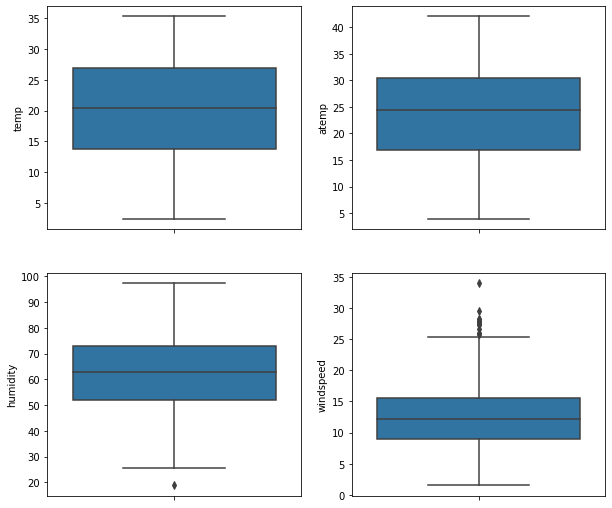

In [35]:
cols_for_boxplot = ["temp", "atemp", "humidity", "windspeed"]

plt.gcf().set_size_inches(10,9)

for i,j in enumerate(cols_for_boxplot):
    plt.subplot(2,2,i+1)
    sns.boxplot(data = data, y = j)

## Observations :
- There arent any annoying outlier so no need to change or delete any rows
- temp and atemp seems to be similar

## Checking for some collinearity

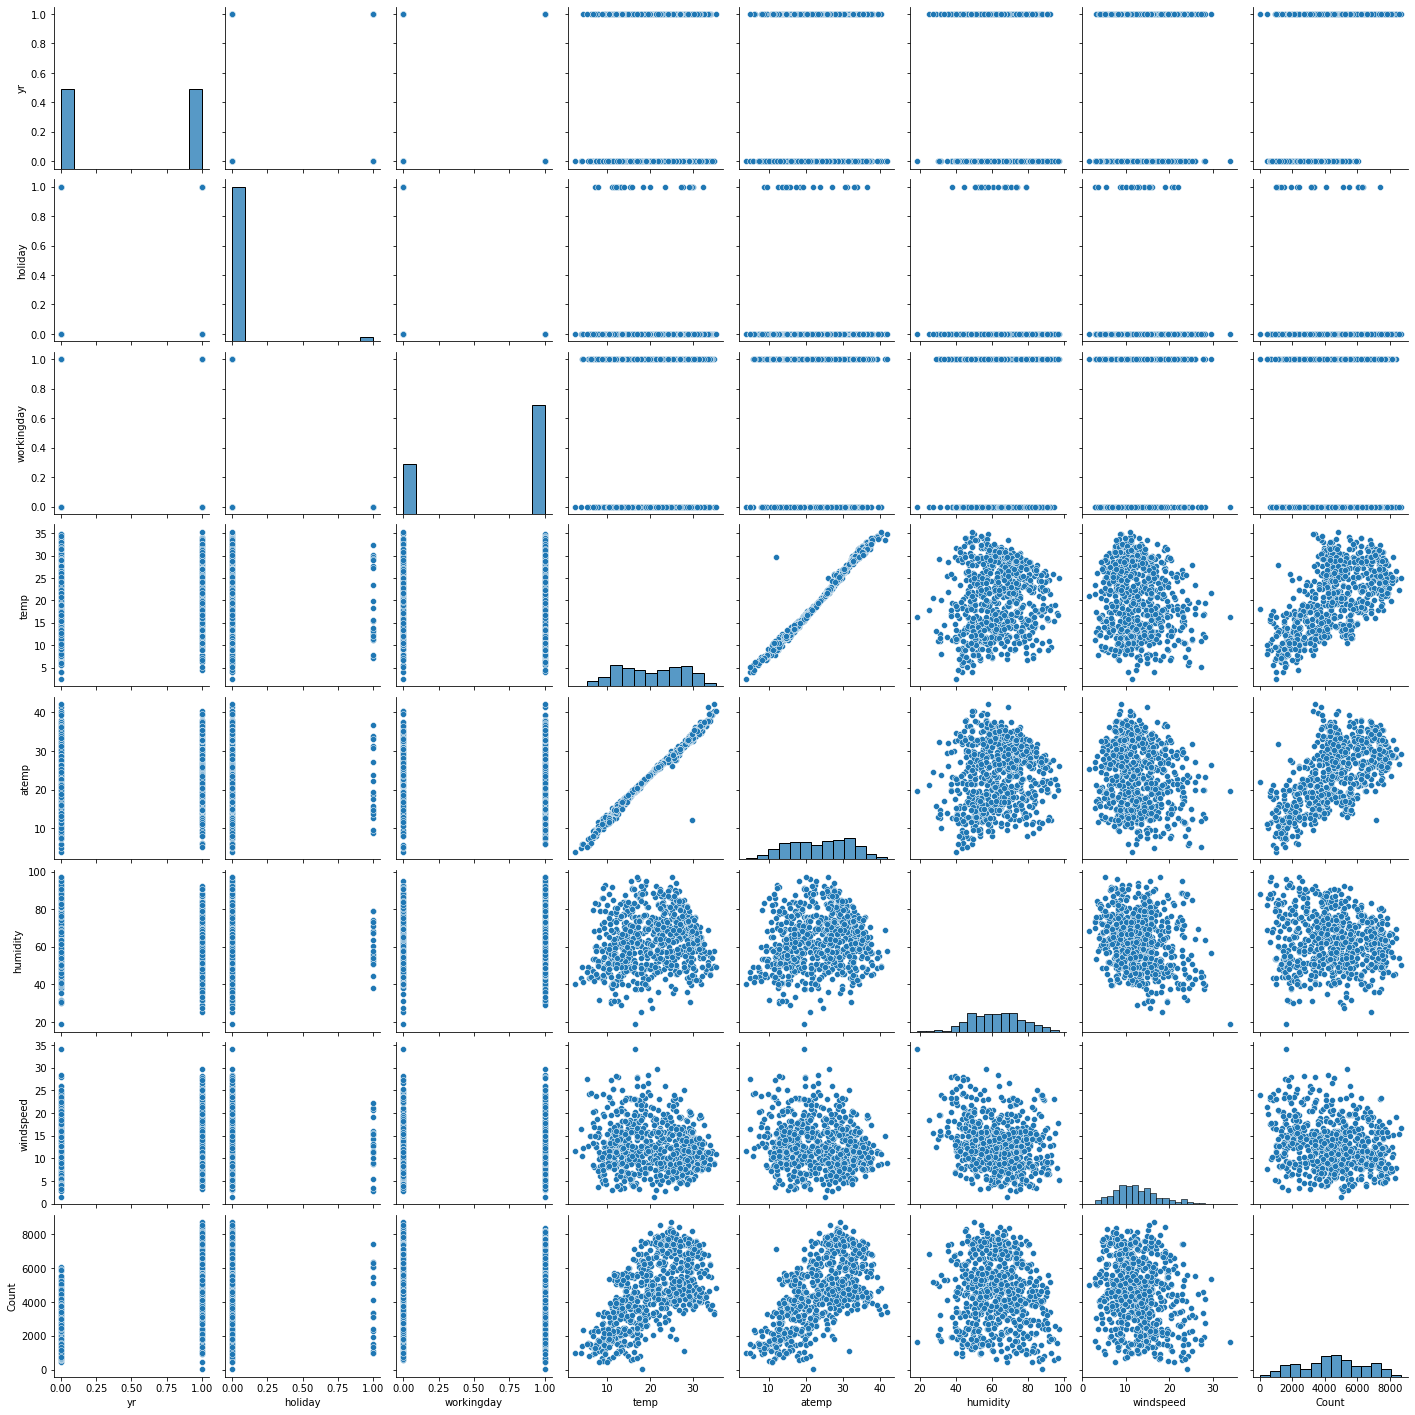

In [36]:
# We will use pairplot to achieve this along with heatmaps

sns.pairplot(data)

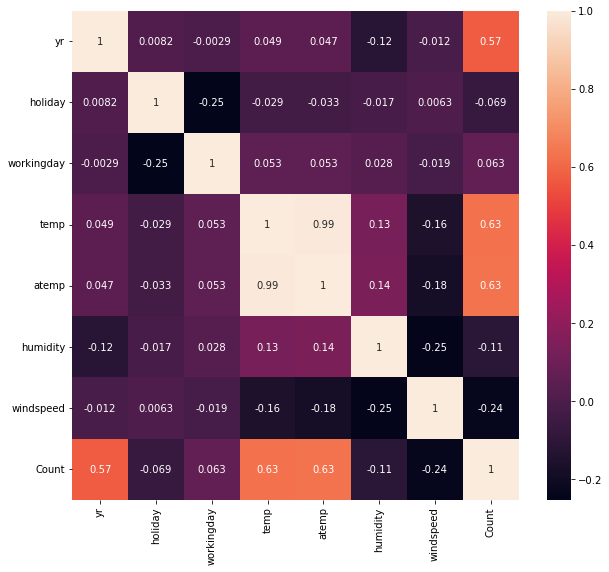

In [37]:
sns.heatmap(data.corr(), annot = True)
plt.gcf().set_size_inches(10,9)

## Observation :
- temp and atemp shows high collinearity, this could be a problem while building our model
- Also there exists some linear relationship between temp and cnt, atemp and cnt
- A positive corelation can be observed between yr and cnt as well

<AxesSubplot:xlabel='Count', ylabel='windspeed'>

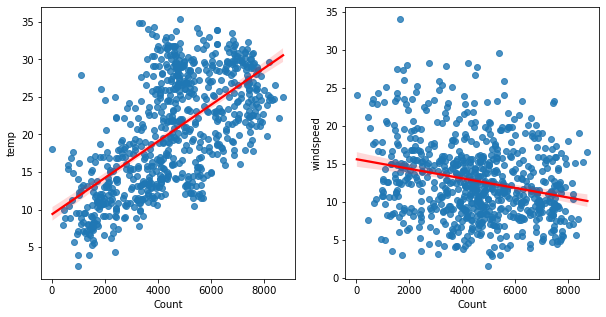

In [38]:
# Temp vs count and windspeed vs Count

plt.figure(figsize=(10,5))

plt.subplot(121)
sns.regplot(x = data["Count"], y = data["temp"], line_kws={"color" : "r"})

plt.subplot(122)
sns.regplot(x = data["Count"], y = data["windspeed"], line_kws={"color" : "r"})

<AxesSubplot:xlabel='Count', ylabel='temp'>

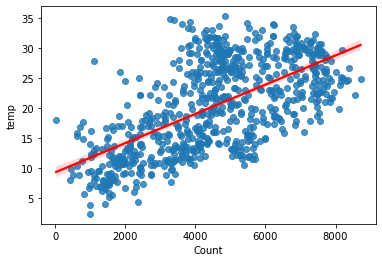

In [39]:
sns.regplot(x = data["Count"], y = data["temp"], line_kws={"color" : "r"})

## Observations:
- A linear relationship can be seen; a positive one in the first plot and a negative one in the second plot
- Temp has a postive linear relationship with Count which can be decued from the plot and ehatmap above
- Windspeed has a negative moderately linear relationship  with Count

<AxesSubplot:xlabel='Count', ylabel='humidity'>

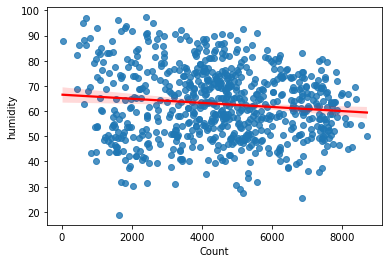

In [40]:
sns.regplot(x = data["Count"], y = data["humidity"], line_kws={"color" : "r"})

## Observations:
- We can see a moderately negative correlation between humidity and Count

## Let's visualise our data using bivariate and multi variate analysis

In [41]:
data.columns

Index(['season', 'yr', 'Month', 'holiday', 'weekday', 'workingday',
       'Weather_condition', 'temp', 'atemp', 'humidity', 'windspeed', 'Count'],
      dtype='object')

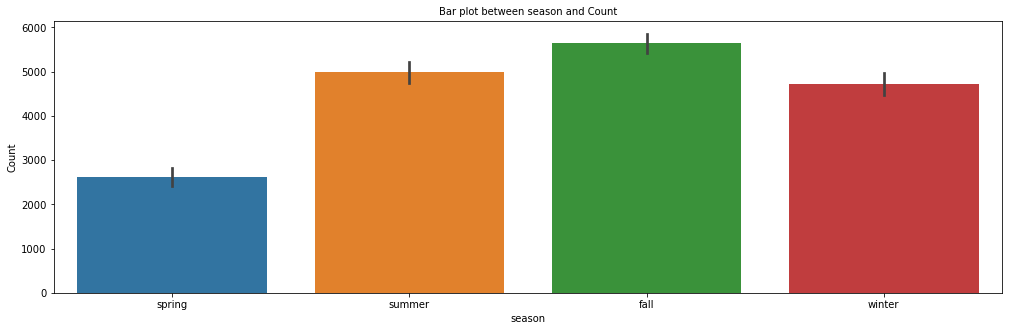

In [42]:
x = "season"
y = "Count"

plots(x = x, y = y, bar_plot = True)

## Observations :
- Fall and summer shows the highest count 
- This could be due to the summer vacation which typicall lasts for 2 and a half months
- Some students also prefer riding bikes to school which can explain the rise in count in fall

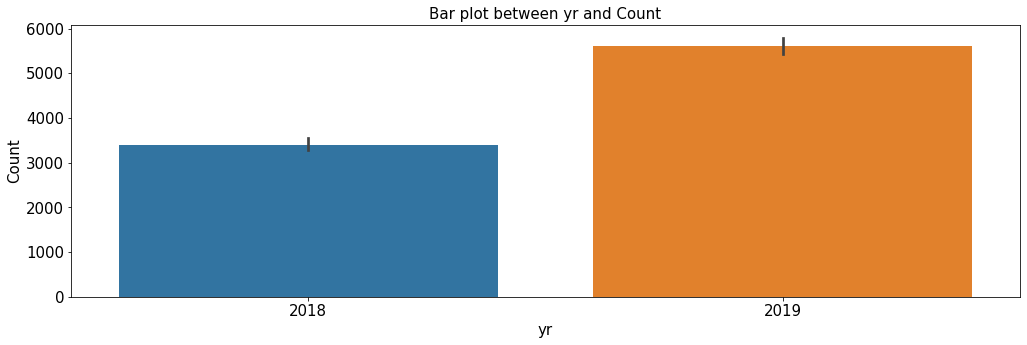

In [43]:
x = "yr"
y = "Count"

plots(x = x, y = y, bar_plot = True, fontsize=15)
plt.xticks(ticks = [0,1], labels = ["2018", "2019"])
plt.show()

## Observations :
- The business is growing for Boombikes in 2019 which is a good indicator for the company

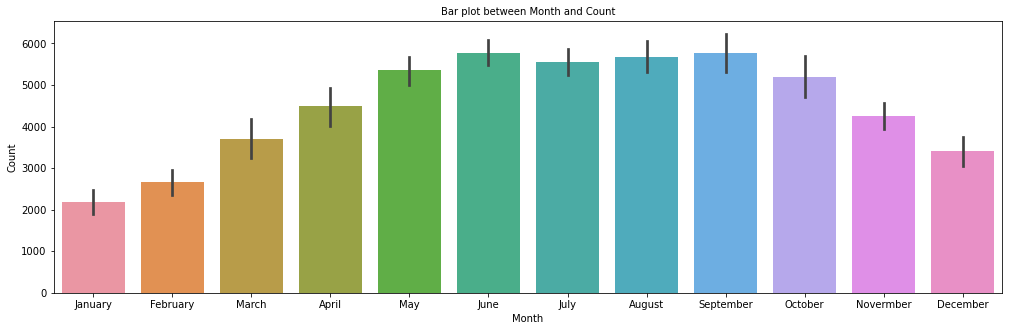

In [44]:
x = "Month"
y = "Count"

plots(x = x, y = y, bar_plot = True)

## Observations :
- summer runs from June 1 to August 31; fall (autumn) runs from September 1 to November 30 which explains the higher bike count in those months
- resource :https://www.google.com/search?client=firefox-b-d&q=summer+and+fall+in+US

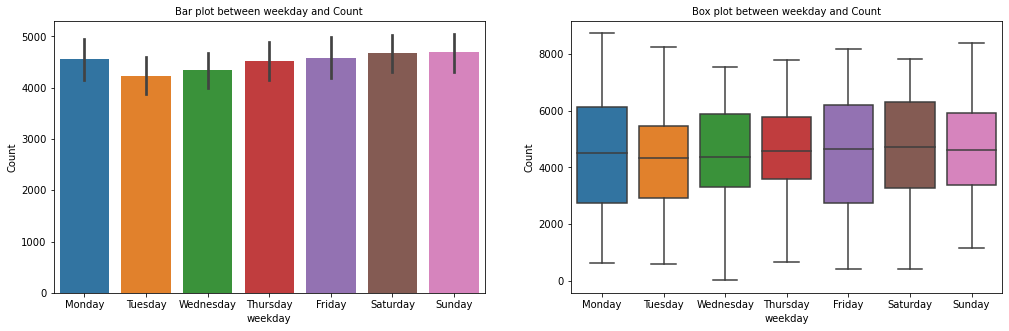

In [45]:
x = "weekday"
y = "Count"
plt.subplot(121)
plots(x = x, y = y, bar_plot = True)

plt.subplot(122)
plots(x = x, y = y, box_plot = True)

## Observations:
- It seems that the count is evenly distributed accross the days of the week
- no specific apttern observed

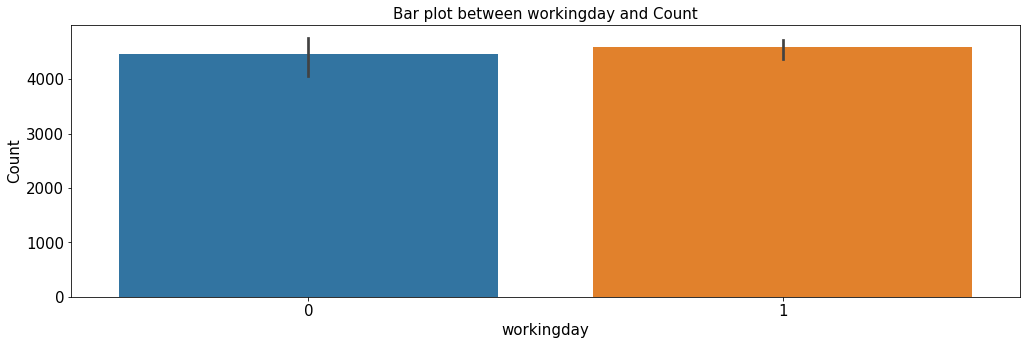

In [46]:
x = "workingday"
y = "Count"

plots(x = x, y = y, bar_plot = True, fontsize=15, estimator=np.median)


## Observations:
- No pattern can be uncovered from this data

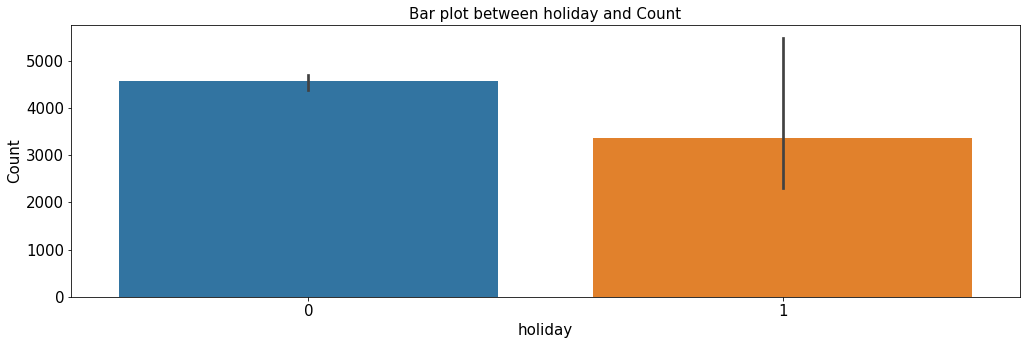

In [47]:
x = "holiday"
y = "Count"

plots(x = x, y = y, bar_plot = True, fontsize=15, estimator=np.median)


## Observations :
- People who tend to be working tend have a higher bike count

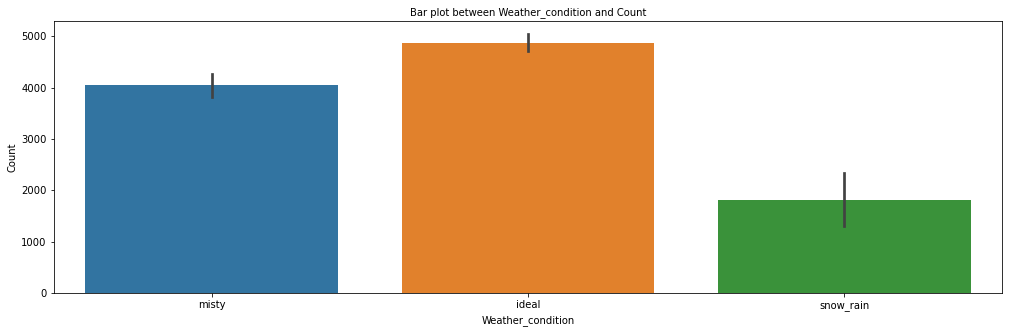

In [48]:
x = "Weather_condition"
y = "Count"

plots(x = x, y = y, bar_plot = True)


## Observations :
- People tend to ride bikes when the weather is misty or ideal which makes sense given that the weather condition palys a mojor role in deciding to whether ride a bike or not

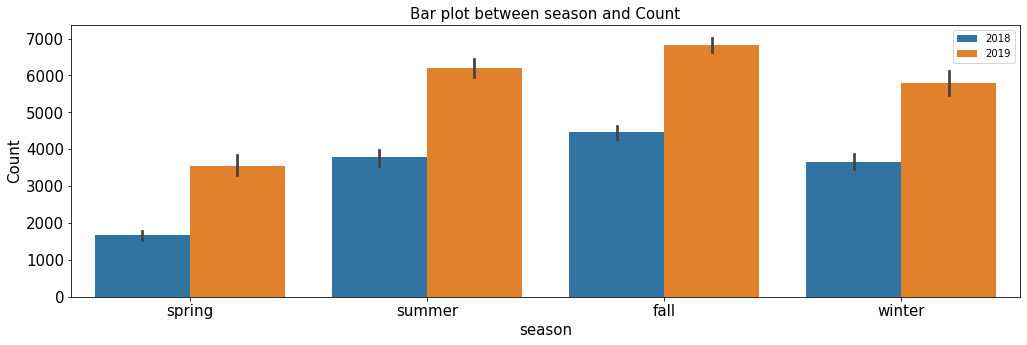

In [49]:
x = "season"
y = "Count"
hue = "yr"
plots(x = x, y = y, bar_plot = True, hues = hue, fontsize=15)
labels = plt.legend()
labels.get_texts()[0].set_text("2018")
labels.get_texts()[1].set_text("2019")

## Observations:
- As we have already seen that there is year on yeat growth and this is evident across various seasons

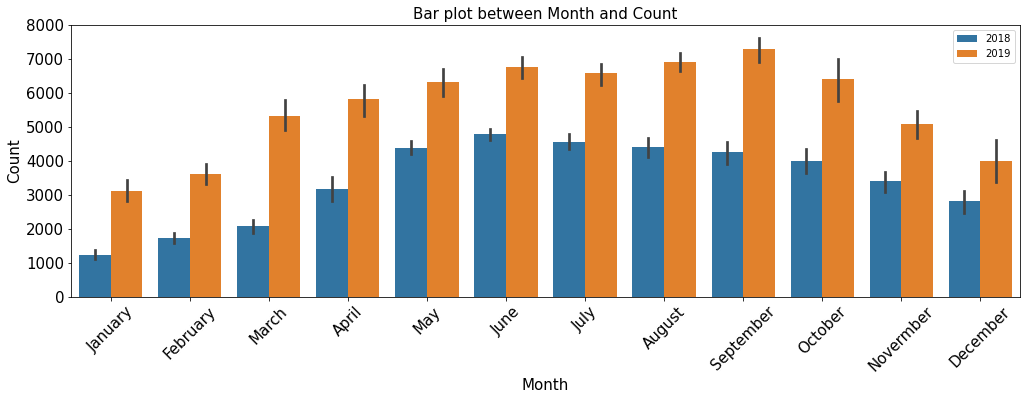

In [50]:
x = "Month"
y = "Count"
hue = "yr"
plots(x = x, y = y, bar_plot = True, hues = hue, fontsize=15, rotation = 45)

labels = plt.legend()
labels.get_texts()[0].set_text("2018")
labels.get_texts()[1].set_text("2019")

## Observations:
- This plot shows the same results of year on year growth and the growht hasnt dipped when compared to 2019

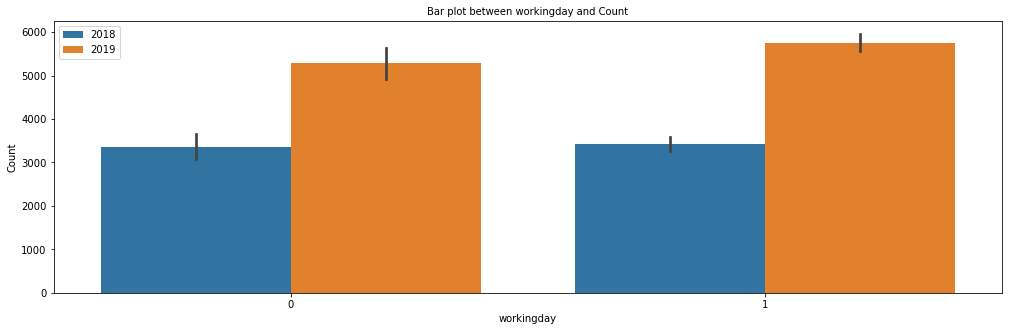

In [51]:
x = "workingday"
y = "Count"
hue = "yr"
plots(x = x, y = y, bar_plot = True, hues = hue)

labels = plt.legend()
labels.get_texts()[0].set_text("2018")
labels.get_texts()[1].set_text("2019")



## Observations:
- The same can be said about this plot

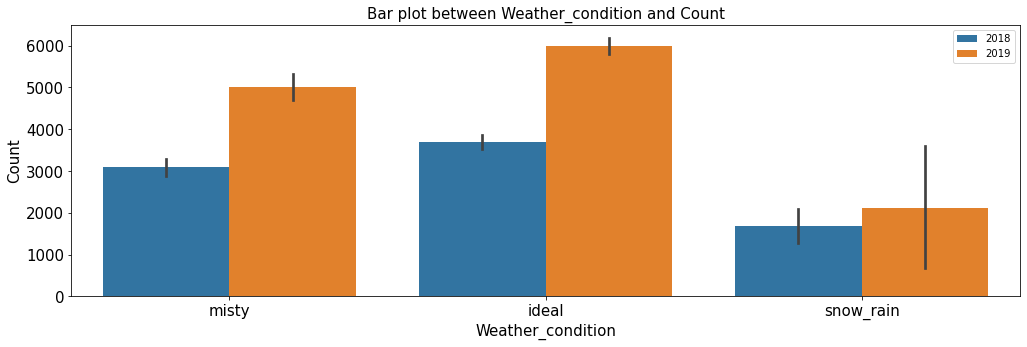

In [52]:
x = "Weather_condition"
y = "Count"
hue = "yr"
plots(x = x, y = y, bar_plot = True, hues = hue, fontsize=15)

labels = plt.legend()
labels.get_texts()[0].set_text("2018")
labels.get_texts()[1].set_text("2019")

### We have finished with our EDA and now let's beging with building and preparing our data for the same

## Pre-processing data

In [53]:
data.head()

,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,windspeed,Count
0,spring,0,January,0,Monday,0,misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,January,0,Tuesday,0,misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,January,0,Wednesday,1,ideal,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,January,0,Thursday,1,ideal,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,January,0,Friday,1,ideal,9.305237,11.46350,43.6957,12.522300,1600


In [54]:
data.shape

(730, 12)

### Creating dummy variables for categorical data :- season, Month, weekday and Weather_condition
- We do this to improve the computational time and accuracy of our model


In [55]:
dummy_season = pd.get_dummies(data["season"], drop_first = True)

dummy_Month = pd.get_dummies(data["Month"], drop_first = True)

dummy_weekday = pd.get_dummies(data["weekday"], drop_first = True)

dummy_Weather_condition = pd.get_dummies(data["Weather_condition"], drop_first = True)

In [56]:
dummy_season



,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
725,1,0,0
726,1,0,0
727,1,0,0
728,1,0,0


In [57]:
dummy_Month

,August,December,February,January,July,June,March,May,Novermber,October,September
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
725,0,1,0,0,0,0,0,0,0,0,0
726,0,1,0,0,0,0,0,0,0,0,0
727,0,1,0,0,0,0,0,0,0,0,0
728,0,1,0,0,0,0,0,0,0,0,0


In [58]:
dummy_weekday

,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
725,0,1,0,0,0,0
726,0,0,1,0,0,0
727,1,0,0,0,0,0
728,0,0,0,0,1,0


In [59]:
dummy_Weather_condition

,misty,snow_rain
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0
...,...,...
725,1,0
726,1,0
727,1,0
728,0,0


In [60]:
# Let's concatenate this to our original data but we will spare changes in the orignal data
# We will create a new variable which stores all the data

data1 = pd.concat([data, dummy_season, dummy_Month, dummy_weekday, dummy_Weather_condition], axis = 1)
data1.head()

,season,yr,Month,holiday,weekday,workingday,Weather_condition,temp,atemp,humidity,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,misty,snow_rain
0,spring,0,January,0,Monday,0,misty,14.110847,18.18125,80.5833,...,0,0,1,0,0,0,0,0,1,0
1,spring,0,January,0,Tuesday,0,misty,14.902598,17.68695,69.6087,...,0,0,0,0,0,0,1,0,1,0
2,spring,0,January,0,Wednesday,1,ideal,8.050924,9.47025,43.7273,...,0,0,0,0,0,0,0,1,0,0
3,spring,0,January,0,Thursday,1,ideal,8.200000,10.60610,59.0435,...,0,0,0,0,0,1,0,0,0,0
4,spring,0,January,0,Friday,1,ideal,9.305237,11.46350,43.6957,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# It's time to drop the original columns

data1.drop(["season", "Month", "weekday", "Weather_condition"], axis = 1, inplace = True)

In [62]:
data1.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'Count', 'spring', 'summer', 'winter', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'Novermber', 'October',
       'September', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'misty', 'snow_rain'],
      dtype='object')

In [63]:
data1.head()

,yr,holiday,workingday,temp,atemp,humidity,windspeed,Count,spring,summer,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,misty,snow_rain
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

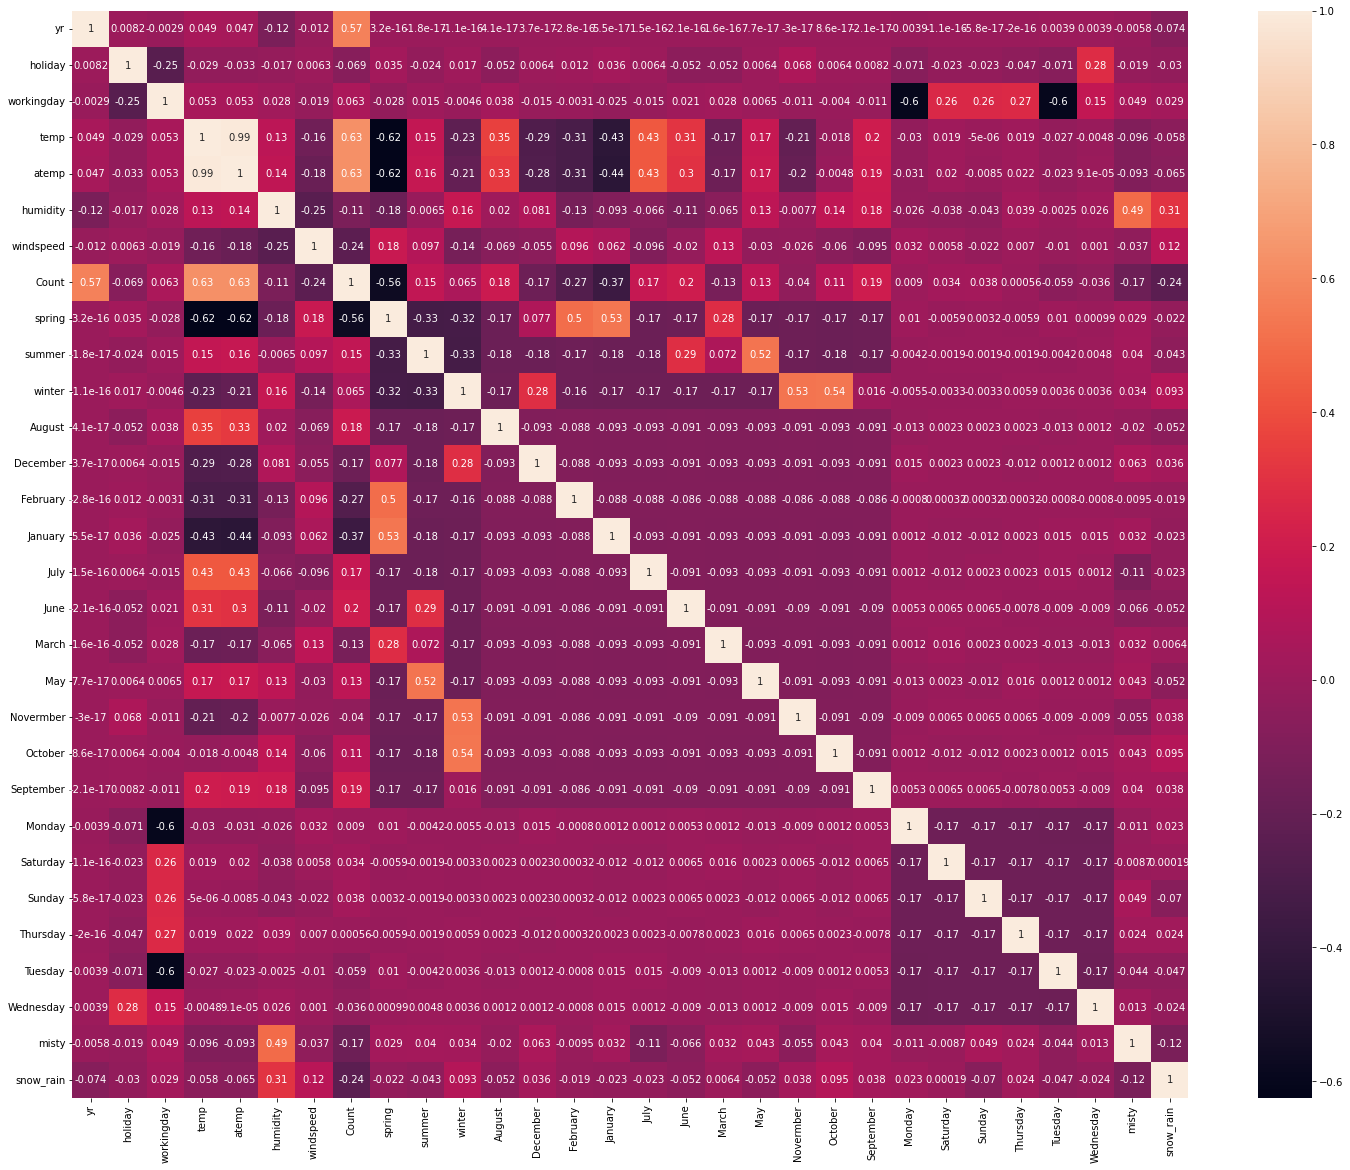

In [64]:
plt.figure(figsize = (25,20))

sns.heatmap(data1.corr(), annot=True)

## Observations:
- Temp and atemp are almost perfectly correlated almost and each of them have the same correlation with  our targeted variable Count which means that one of the two is enough to represent temperature
- Yr is also positively correalated with Count as we saw an increase in count as year progresses



In [65]:
data1.drop("atemp", axis= 1, inplace=True)

### Feature Scaling our numerical data:- temp, atemp, humidity, Count

In [66]:
# Let's split the data into training and test set before we scale otherwise we risk leaking data into our test set

In [67]:
train_df, test_df = train_test_split(data1, train_size = 0.7, test_size=0.3, random_state=100)

In [68]:
print(train_df.shape)
print(test_df.shape)

(510, 29)
(219, 29)


<AxesSubplot:>

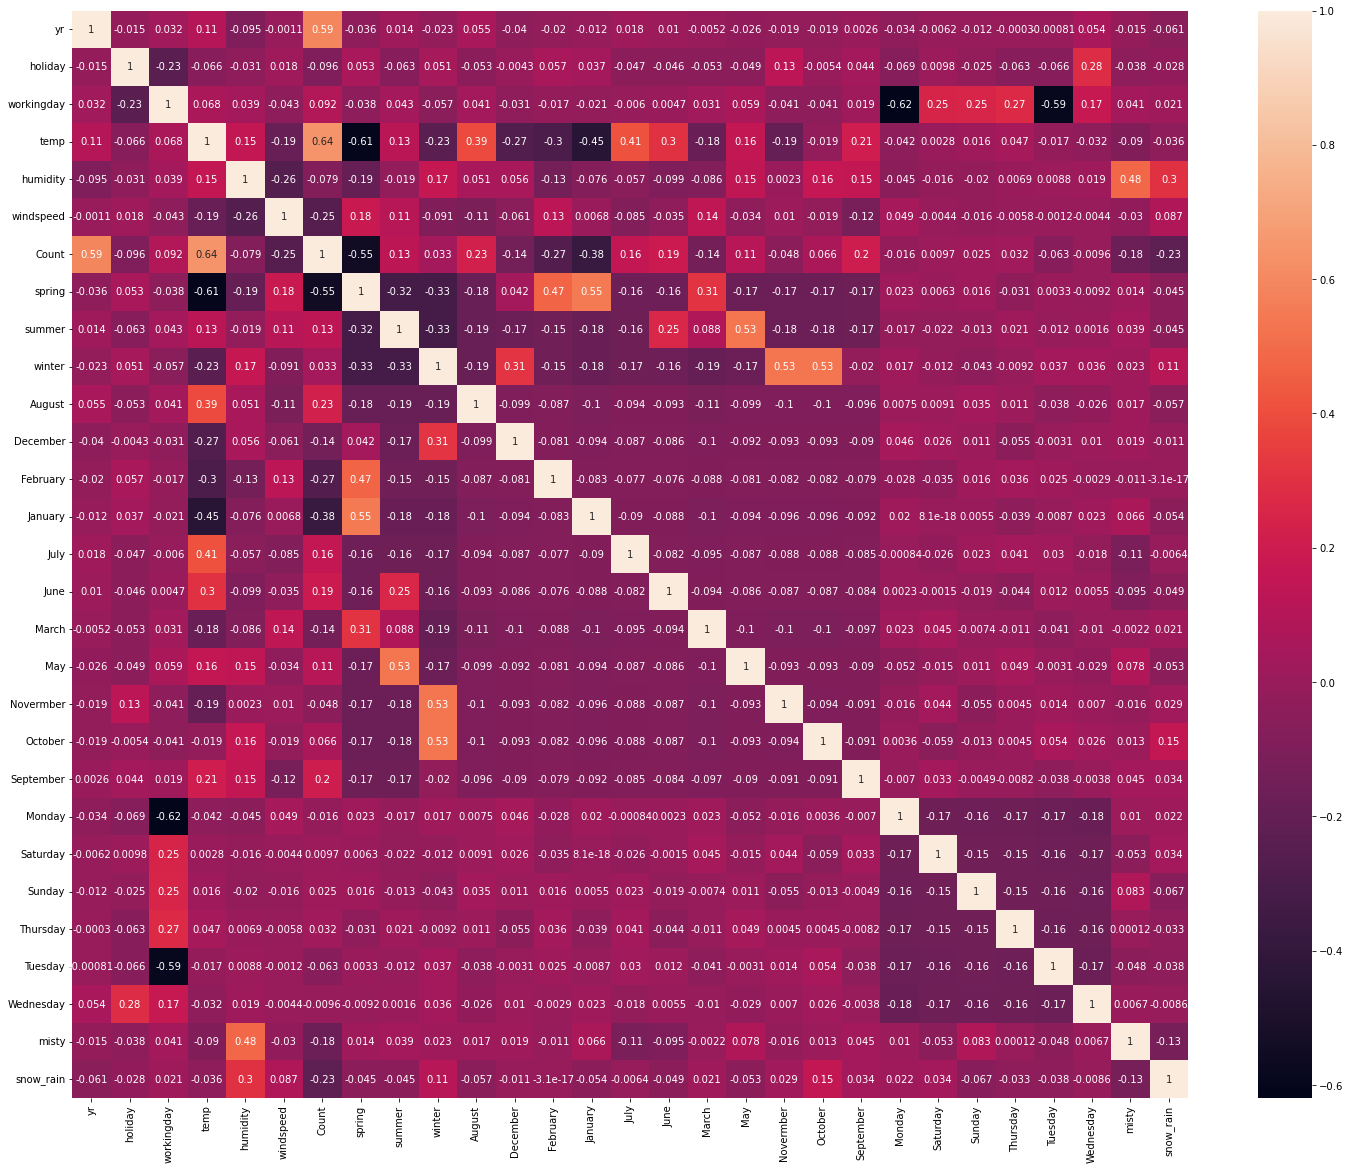

In [69]:
plt.figure(figsize = (25,20))

sns.heatmap(train_df.corr(), annot=True)

## Observations:
- We can see high negavtive and positive correlation
- We need to be carefull whiloe buidling our models although majority if the data seems to have low correlation;


In [70]:
scaler = MinMaxScaler() # We will use Normalization to scale the features

In [71]:
numerical_vars = ["temp", "humidity", "windspeed", "Count"]

train_df[numerical_vars] = scaler.fit_transform(train_df[numerical_vars])

In [72]:
train_df[numerical_vars].describe()

,temp,humidity,windspeed,Count
count,510.000000,510.000000,510.000000,510.000000
mean,0.537262,0.567975,0.320768,0.513620
std,0.225844,0.177341,0.169797,0.224593
min,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.428913,0.199179,0.356420
50%,0.540519,0.570553,0.296763,0.518638
75%,0.735215,0.695953,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000


#### All the values of our numerical variables are scaled from 0 to 1

In [73]:
train_df.head()

,yr,holiday,workingday,temp,humidity,windspeed,Count,spring,summer,winter,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,misty,snow_rain
653,1,0,1,0.509887,0.473375,0.300794,0.864243,0,0,1,...,1,0,0,0,0,1,0,0,0,0
576,1,0,1,0.815169,0.659744,0.264686,0.827658,0,0,0,...,0,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.553780,0.255342,0.465255,1,0,0,...,0,0,1,0,0,0,0,0,1,0
728,1,0,0,0.245101,0.377528,0.663106,0.204096,1,0,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.395666,0.385516,0.188475,0.482973,0,1,0,...,0,0,1,0,0,0,0,0,1,0


## Data Modelling

### Splitting the data into X_train and y_train



In [74]:
y_train = train_df.pop("Count")
X_train = train_df

In [75]:
print(y_train.shape)
print(X_train.shape)

(510,)
(510, 28)


In [76]:
X_train.head()

,yr,holiday,workingday,temp,humidity,windspeed,spring,summer,winter,August,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,misty,snow_rain
653,1,0,1,0.509887,0.473375,0.300794,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
576,1,0,1,0.815169,0.659744,0.264686,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.553780,0.255342,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
728,1,0,0,0.245101,0.377528,0.663106,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.395666,0.385516,0.188475,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


### We will first use Recursive feature elimination(RFE) and from there we will use our manual approach to eliminate other features

In [77]:
# Let's define some functions so we dont have to write the same line of code again and again

def VIF_score(X):
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [round(variance_inflation_factor(X.values, i),2) for i in range(X.shape[1])]
    vif = vif.sort_values(by = "VIF", ascending=False)
    return vif



def OLS_model(X_train_data, y_train = y_train, return_model = False):
    
    X_train_sm = sm.add_constant(X_train_data)
    ols = OLS(y_train, X_train_sm)
    model = ols.fit()
    
    if return_model:
        return model
    else:
        return model.summary()

### For RFE we need to use Sklearn's regression model and then proceed with the estimator

In [78]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [79]:
rfe = RFE(regressor, n_features_to_select = 15, step = 0.35)
rfe_model = rfe.fit(X_train, y_train)

In [80]:
rfe_data = pd.DataFrame()
rfe_data["features"] = X_train.columns
rfe_data["Support"] = rfe_model.support_
rfe_data["Rankings"] = rfe_model.ranking_
rfe_data.sort_values(by = "Rankings")

,features,Support,Rankings
0,yr,True,1
24,Tuesday,True,1
20,Monday,True,1
19,September,True,1
26,misty,True,1
12,January,True,1
10,December,True,1
8,winter,True,1
27,snow_rain,True,1
6,spring,True,1


### The features above with rank 1 and support true are selected by our RFE which is best suited for our regression but we will check the p-values and vif scores to see whether they are indeed the best or a manual approach is needed 

In [81]:
X_train.columns[rfe_model.support_] # These are features selected by RFE

Index(['yr', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'spring', 'winter', 'December', 'January', 'September', 'Monday',
       'Tuesday', 'misty', 'snow_rain'],
      dtype='object')

In [82]:
X_train_rfe_cols = X_train.columns[rfe_model.support_]


In [83]:
X_train_rfe = X_train[X_train_rfe_cols]
X_train_rfe.head()

,yr,holiday,workingday,temp,humidity,windspeed,spring,winter,December,January,September,Monday,Tuesday,misty,snow_rain
653,1,0,1,0.509887,0.473375,0.300794,0,1,0,0,0,0,0,0,0
576,1,0,1,0.815169,0.659744,0.264686,0,0,0,0,0,0,0,0,0
426,1,0,0,0.442393,0.553780,0.255342,1,0,0,0,0,1,0,1,0
728,1,0,0,0.245101,0.377528,0.663106,1,0,1,0,0,0,1,0,0
482,1,0,0,0.395666,0.385516,0.188475,0,0,0,0,0,1,0,1,0


In [84]:
OLS_model(X_train_data = X_train_rfe)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     186.5
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          4.67e-187
Time:                        18:59:06   Log-Likelihood:                 506.86
No. Observations:                 510   AIC:                            -983.7
Df Residuals:                     495   BIC:                            -920.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2446      0.023     10.711      0.000       0.200       0.290
yr             0.2331      0.008     28.433      0.000       0.217       0.249
holiday       -0.0072      0.021     -0.338      0.736      -0.049       0.035
workingday     0.0961      0.009     10.739      0.000       0.079       0.114
temp           0.3984      0.030     13.079      0.000       0.339       0.458
humidity      -0.0975      0.033     -2.993      0.003      -0.161      -0.033
windspeed     -0.1751      0.026     -6.713      0.000      -0.226      -0.124
spring        -0.0992      0.015     -6.410      0.000      -0.130      -0.069
winter         0.0579      0.013      4.544      0.000       0.033       0.083
December      -0.0359      0.016     -2.224      0.027      -0.068      -0.004
January       -0.0558      0.018     -3.104      0.002      -0.091      -0.020
September      0.0704      0.015      4.583      0.000       0.040       0.101
Monday         0.1058      0.011      9.397      0.000       0.084       0.128
Tuesday        0.0499      0.012      4.271      0.000       0.027       0.073
misty         -0.0602      0.011     -5.528      0.000      -0.082      -0.039
snow_rain     -0.2596      0.028     -9.367      0.000      -0.314      -0.205
==============================================================================
Omnibus:                       77.042   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.248
Skew:                          -0.749   Prob(JB):                     2.70e-45
Kurtosis:                       5.723   Cond. No.                     1.30e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.53e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [85]:
VIF_score(X = X_train_rfe)

,features,VIF
2,workingday,32.53
11,Monday,8.14
12,Tuesday,7.81
3,temp,2.92
6,spring,2.72
1,holiday,2.22
4,humidity,2.05
7,winter,1.87
13,misty,1.65
9,January,1.61


## Observations and Intepretation:
- First we will emphasize features having high p-value and eliminate them
- Eliminating certain features may alter the VIF value of some features
- After having the p-values close to zero or atleast less than 5% (0.05) we can proceed elimianting features with high VIF values

### In a broad sense we will combine RFE and manual  approach to give us the best model

## Model 1

In [86]:
# Eliminating holiday due to high p-value

X_train_rfe = X_train_rfe.drop("holiday", axis = 1)
X_train_rfe.head()

,yr,workingday,temp,humidity,windspeed,spring,winter,December,January,September,Monday,Tuesday,misty,snow_rain
653,1,1,0.509887,0.473375,0.300794,0,1,0,0,0,0,0,0,0
576,1,1,0.815169,0.659744,0.264686,0,0,0,0,0,0,0,0,0
426,1,0,0.442393,0.553780,0.255342,1,0,0,0,0,1,0,1,0
728,1,0,0.245101,0.377528,0.663106,1,0,1,0,0,0,1,0,0
482,1,0,0.395666,0.385516,0.188475,0,0,0,0,0,1,0,1,0


In [87]:
OLS_model(X_train_data=X_train_rfe)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     186.5
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          4.67e-187
Time:                        18:59:06   Log-Likelihood:                 506.86
No. Observations:                 510   AIC:                            -983.7
Df Residuals:                     495   BIC:                            -920.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2374      0.038      6.316      0.000       0.164       0.311
yr             0.2331      0.008     28.433      0.000       0.217       0.249
workingday     0.1033      0.026      3.984      0.000       0.052       0.154
temp           0.3984      0.030     13.079      0.000       0.339       0.458
humidity      -0.0975      0.033     -2.993      0.003      -0.161      -0.033
windspeed     -0.1751      0.026     -6.713      0.000      -0.226      -0.124
spring        -0.0992      0.015     -6.410      0.000      -0.130      -0.069
winter         0.0579      0.013      4.544      0.000       0.033       0.083
December      -0.0359      0.016     -2.224      0.027      -0.068      -0.004
January       -0.0558      0.018     -3.104      0.002      -0.091      -0.020
September      0.0704      0.015      4.583      0.000       0.040       0.101
Monday         0.1130      0.027      4.123      0.000       0.059       0.167
Tuesday        0.0571      0.028      2.075      0.039       0.003       0.111
misty         -0.0602      0.011     -5.528      0.000      -0.082      -0.039
snow_rain     -0.2596      0.028     -9.367      0.000      -0.314      -0.205
==============================================================================
Omnibus:                       77.042   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.248
Skew:                          -0.749   Prob(JB):                     2.70e-45
Kurtosis:                       5.723   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
VIF_score(X = X_train_rfe)

,features,VIF
3,humidity,20.11
1,workingday,15.47
2,temp,15.37
4,windspeed,4.62
10,Monday,4.27
11,Tuesday,4.11
5,spring,3.06
12,misty,2.46
6,winter,2.20
0,yr,2.09


## Model 2

In [89]:
# Eliminating humidity due to high VIf value
X_train_rfe = X_train_rfe.drop("humidity", axis = 1)
X_train_rfe.head()

,yr,workingday,temp,windspeed,spring,winter,December,January,September,Monday,Tuesday,misty,snow_rain
653,1,1,0.509887,0.300794,0,1,0,0,0,0,0,0,0
576,1,1,0.815169,0.264686,0,0,0,0,0,0,0,0,0
426,1,0,0.442393,0.255342,1,0,0,0,0,1,0,1,0
728,1,0,0.245101,0.663106,1,0,1,0,0,0,1,0,0
482,1,0,0.395666,0.188475,0,0,0,0,0,1,0,1,0


In [90]:
OLS_model(X_train_data=X_train_rfe)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.0
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          2.71e-186
Time:                        18:59:06   Log-Likelihood:                 502.29
No. Observations:                 510   AIC:                            -976.6
Df Residuals:                     496   BIC:                            -917.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1966      0.035      5.568      0.000       0.127       0.266
yr             0.2361      0.008     28.794      0.000       0.220       0.252
workingday     0.1040      0.026      3.979      0.000       0.053       0.155
temp           0.3756      0.030     12.634      0.000       0.317       0.434
windspeed     -0.1537      0.025     -6.079      0.000      -0.203      -0.104
spring        -0.1022      0.016     -6.563      0.000      -0.133      -0.072
winter         0.0510      0.013      4.037      0.000       0.026       0.076
December      -0.0402      0.016     -2.481      0.013      -0.072      -0.008
January       -0.0586      0.018     -3.237      0.001      -0.094      -0.023
September      0.0668      0.015      4.329      0.000       0.037       0.097
Monday         0.1156      0.028      4.184      0.000       0.061       0.170
Tuesday        0.0556      0.028      2.005      0.046       0.001       0.110
misty         -0.0799      0.009     -9.149      0.000      -0.097      -0.063
snow_rain     -0.2985      0.025    -12.094      0.000      -0.347      -0.250
==============================================================================
Omnibus:                       77.095   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.318
Skew:                          -0.754   Prob(JB):                     1.17e-44
Kurtosis:                       5.692   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
VIF_score(X = X_train_rfe)

,features,VIF
1,workingday,13.68
2,temp,11.48
3,windspeed,4.52
9,Monday,3.93
10,Tuesday,3.65
4,spring,2.89
0,yr,2.07
5,winter,1.93
7,January,1.70
11,misty,1.57


## Model 3

In [92]:
# Removing workingday due to its high VIF value
X_train_rfe = X_train_rfe.drop("workingday", axis = 1)
X_train_rfe.head()

,yr,temp,windspeed,spring,winter,December,January,September,Monday,Tuesday,misty,snow_rain
653,1,0.509887,0.300794,0,1,0,0,0,0,0,0,0
576,1,0.815169,0.264686,0,0,0,0,0,0,0,0,0
426,1,0.442393,0.255342,1,0,0,0,0,1,0,1,0
728,1,0.245101,0.663106,1,0,1,0,0,0,1,0,0
482,1,0.395666,0.188475,0,0,0,0,0,1,0,1,0


In [93]:
OLS_model(X_train_data=X_train_rfe)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     206.0
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          4.31e-184
Time:                        18:59:06   Log-Likelihood:                 494.28
No. Observations:                 510   AIC:                            -962.6
Df Residuals:                     497   BIC:                            -907.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2971      0.025     11.876      0.000       0.248       0.346
yr             0.2366      0.008     28.440      0.000       0.220       0.253
temp           0.3773      0.030     12.510      0.000       0.318       0.437
windspeed     -0.1557      0.026     -6.069      0.000      -0.206      -0.105
spring        -0.1050      0.016     -6.654      0.000      -0.136      -0.074
winter         0.0474      0.013      3.706      0.000       0.022       0.073
December      -0.0383      0.016     -2.328      0.020      -0.071      -0.006
January       -0.0590      0.018     -3.212      0.001      -0.095      -0.023
September      0.0630      0.016      4.029      0.000       0.032       0.094
Monday         0.0155      0.012      1.339      0.181      -0.007       0.038
Tuesday       -0.0443      0.012     -3.690      0.000      -0.068      -0.021
misty         -0.0780      0.009     -8.813      0.000      -0.095      -0.061
snow_rain     -0.2936      0.025    -11.738      0.000      -0.343      -0.244
==============================================================================
Omnibus:                       92.442   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.770
Skew:                          -0.868   Prob(JB):                     3.21e-58
Kurtosis:                       6.073   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model 4

In [94]:
# Removing Monday due to its high p value

In [95]:
X_train_rfe = X_train_rfe.drop("Monday", axis = 1)
X_train_rfe.head()

,yr,temp,windspeed,spring,winter,December,January,September,Tuesday,misty,snow_rain
653,1,0.509887,0.300794,0,1,0,0,0,0,0,0
576,1,0.815169,0.264686,0,0,0,0,0,0,0,0
426,1,0.442393,0.255342,1,0,0,0,0,0,1,0
728,1,0.245101,0.663106,1,0,1,0,0,1,0,0
482,1,0.395666,0.188475,0,0,0,0,0,0,1,0


In [96]:
VIF_score(X = X_train_rfe)

,features,VIF
2,windspeed,3.95
1,temp,3.84
3,spring,2.35
0,yr,2.06
6,January,1.64
4,winter,1.61
9,misty,1.51
5,December,1.28
8,Tuesday,1.17
7,September,1.16


## Inference:
- The p-values of all the features are close to zero and the VIFs are very well within 5 so we will consider Model 4 as our final model and proceed with the same
- Also the variables are able to explain around 83% of variance which is a good sign

<AxesSubplot:>

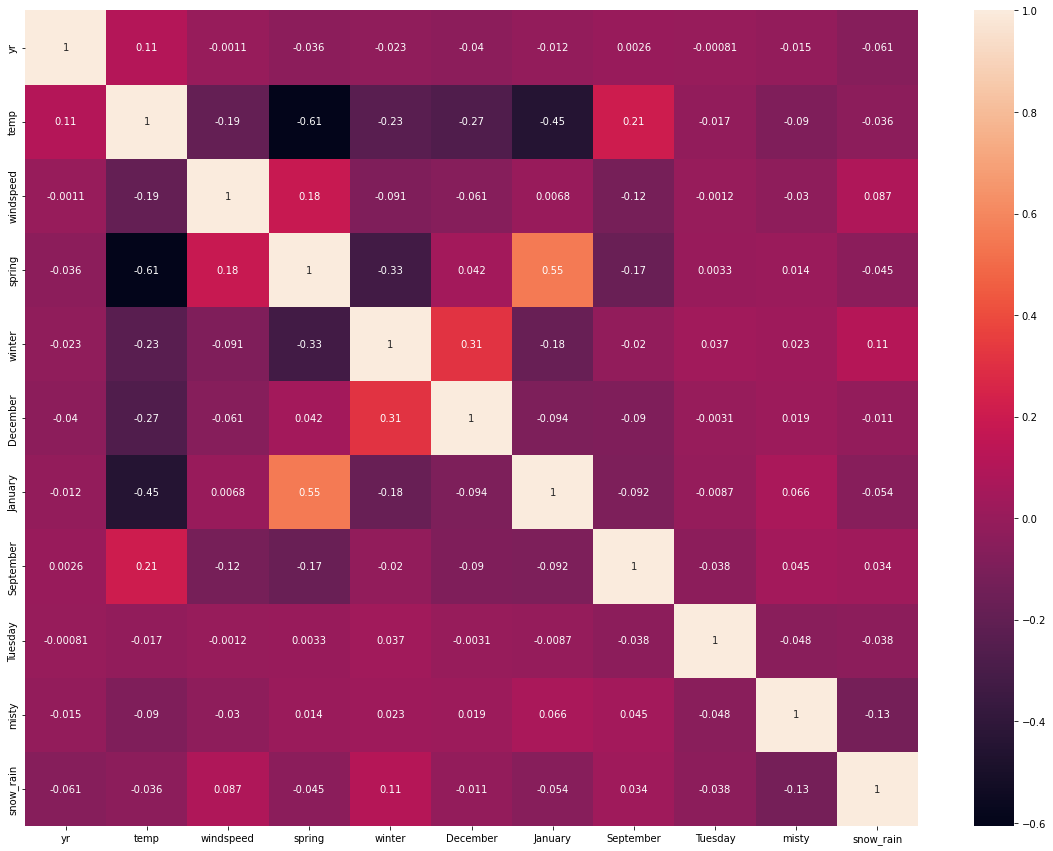

In [97]:
plt.figure(figsize=(20,15))
sns.heatmap(X_train_rfe.corr(), annot=True)

## Obsrvations:
- There are no sogns of high negative or positiv correlation, the benchmark for such inference is as follows
- We are considering anything beyond 60% as high correlation

In [98]:
lr_model = OLS_model(X_train_data=X_train_rfe, return_model=True)

In [99]:
lr_model.params

const        0.299477
yr           0.236298
temp         0.377143
windspeed   -0.154046
spring      -0.105047
winter       0.047588
December    -0.037435
January     -0.058615
September    0.062998
Tuesday     -0.047060
misty       -0.077965
snow_rain   -0.293356
dtype: float64

### We will have the following equation:
Y(COUNT) = $ 0.299477 + (yr * 0.236298) + (temp * 0.377143) - (windspeed * 0.154046) - (spring * 0.105047) + (winter * 0.047588) - (December * 0.037435) - (January * 0.058615) + (September * 0.062998) - (Tuesday * 0.047060) - (Misty * 0.077965) - (snow_rain * 0.293356) $

In [100]:
# Before we go on and test our model on the test set, we need to validate some assumptions

## Assumptions of Linear Regressions are as follows :
- There should exist some lienar relationship between X and Y
- The error terms should be normall distributed
- Independence of error terms
- The error terms must show constant variation (Homoscedasticity)

### 1) We already proved that there exists some linear relationship earlier on in the notebook


### 2) The error terms should be normally distributed around 0

In [101]:
X_train_rfe_sm = sm.add_constant(X_train_rfe)
y_train_pred = lr_model.predict(X_train_rfe_sm)
residuals = y_train - y_train_pred

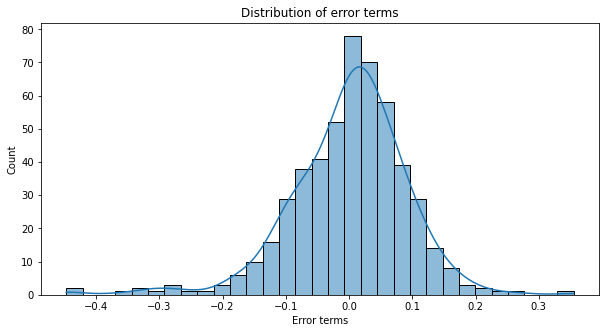

In [102]:
sns.histplot(residuals, kde = True)
plt.title("Distribution of error terms")
plt.xlabel("Error terms")

plt.gcf().set_size_inches(10,5)

In [103]:
np.std(residuals)

0.09196820146083644

In [104]:
np.mean(residuals)

-2.83166736246429e-15

## Observations:
- The mean of the residuals from the graph and from the calculation below validate our second assumptions

## The error terms must show constant variation (Homoscedasticity)

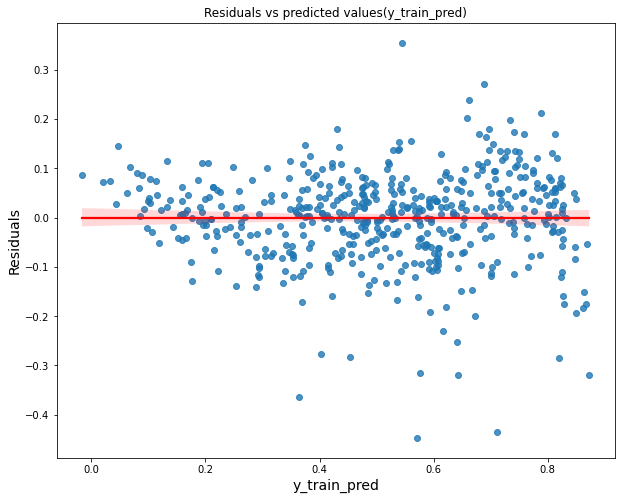

In [105]:
sns.regplot(x = y_train_pred, y = residuals, line_kws = {"color" : "red"})
plt.title("Residuals vs predicted values(y_train_pred)")
plt.xlabel("y_train_pred", fontdict={"fontsize" : 14})
plt.ylabel("Residuals", fontdict={"fontsize" : 14})
plt.gcf().set_size_inches(10,8)

## Observations:
- No visibile pattern can be noticed and this indicates that there is now lower or higher concentration of points and the residuals are evenly distributed
- The graph above proves our 3rd and 4th assumption of linear regressions



In [106]:
lr_model.params

const        0.299477
yr           0.236298
temp         0.377143
windspeed   -0.154046
spring      -0.105047
winter       0.047588
December    -0.037435
January     -0.058615
September    0.062998
Tuesday     -0.047060
misty       -0.077965
snow_rain   -0.293356
dtype: float64

## Let's interprete these features one by one
### -  Yr - For every increase in variable Yr the Count increases by 0.236298 units
### -  temp - For every increase in variable Temp the Count increases by 0.377143 units
### -  windspeed - For every increase in variable windspeed the Count decreases by 0.154046 units
### -  spring - For every increase in variable spring the Count decreases by 0.105047 units
### -  winter - For every increase in variable winter the Count increases by 0.047588 units
### -  December - For every increase in variable December the Count decreases by 0.037435 units
### -  January -  For every increase in variable January the Count decreases by 0.058615 units
### -  September - For every increase in variable September the Count increases by 0.062998 units
### -  Tuesday - For every increase in variable March the Count increases by 0.047060 units
### -  misty- For every increase in variable Ideal the Count increases by 0.077965 units
### -  snow_rain - For every increase in variable snow_rain the Count decreases by 0.293356 units


In [107]:
# The variables matches with our analysis in EDA, as the temp decreases there is a decrease in rentals and as the temp increases we see a increase in rentals
# the weather condition "snow_rain" also states tells us that people prefer riding bikes when the weather is Ideal and Misty
# We also saw a moderately negative linear relationship of windspeed vs count and this model also conveys the same
# For months we can see that w.r.t September the count actually shows signs of decrease for January and february which also compliments our analysis in EDA 
# The yr variable also shows a positive relationship with count; the same which we deduced
# Our model considering the variables should be able to explain the data well cause it compliments our analysis in EDA

### We have proved all the assumption of Linear Regression and its time to actually test our model on the test set and see how it performs

## Evaluating our Model on the Test set
### -  First we will scale all the values using the object (scaler) whci hwe used to scale the features of our training            set
### -  We will split the test set into X_test and y_test
### -  Then we will remove all the unecessary columns from our X_test and perform our final pre processing on                X-test
### -  And finally we make our model predict the value based on the data(X_test) supplied

### Scaling our Test set

In [108]:
test_df



,yr,holiday,workingday,temp,humidity,windspeed,Count,spring,summer,winter,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,misty,snow_rain
184,0,1,0,29.793347,63.7917,5.459106,6043,0,0,0,...,0,0,0,0,0,0,0,1,1,0
535,1,0,1,32.082500,59.2083,7.625404,6211,0,1,0,...,0,0,0,0,0,0,0,0,0,0
299,0,0,1,19.270000,81.2917,13.250121,2659,0,0,1,...,1,0,0,1,0,0,0,0,1,0
221,0,0,1,31.433347,42.4167,13.417286,4780,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,29.315000,30.5000,19.583229,4968,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1,0,0,10.899153,68.7917,11.791732,2947,1,0,0,...,0,0,0,0,0,0,1,0,1,0
702,1,0,1,19.509153,73.3750,11.666643,6606,0,0,1,...,0,0,0,0,0,1,0,0,0,0
127,0,0,0,21.661653,63.1667,5.000712,4333,0,1,0,...,0,0,0,0,0,0,1,0,0,0
640,1,0,1,26.957500,79.3750,4.458569,7572,0,0,1,...,1,0,0,0,0,0,0,0,1,0


In [109]:
test_df[numerical_vars] = scaler.transform(test_df[numerical_vars])
test_df

,yr,holiday,workingday,temp,humidity,windspeed,Count,spring,summer,winter,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,misty,snow_rain
184,0,1,0,0.831783,0.575080,0.084219,0.692706,0,0,0,...,0,0,0,0,0,0,0,1,1,0
535,1,0,1,0.901354,0.516506,0.153728,0.712034,0,1,0,...,0,0,0,0,0,0,0,0,0,0
299,0,0,1,0.511964,0.798722,0.334206,0.303382,0,0,1,...,1,0,0,1,0,0,0,0,1,0
221,0,0,1,0.881625,0.301917,0.339570,0.547400,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.817246,0.149627,0.537414,0.569029,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1,0,0,0.257562,0.638978,0.287411,0.336516,1,0,0,...,0,0,0,0,0,0,1,0,1,0
702,1,0,1,0.519232,0.697550,0.283397,0.757478,0,0,1,...,0,0,0,0,0,1,0,0,0,0
127,0,0,0,0.584649,0.567093,0.069510,0.495973,0,1,0,...,0,0,0,0,0,0,1,0,0,0
640,1,0,1,0.745598,0.774227,0.052115,0.868615,0,0,1,...,1,0,0,0,0,0,0,0,1,0


### Splitting our test set into X_test and y_test

In [110]:
y_test = test_df.pop("Count")
X_test = test_df

### Dropping uncessary columns

In [111]:
X_train_rfe.columns

Index(['yr', 'temp', 'windspeed', 'spring', 'winter', 'December', 'January',
       'September', 'Tuesday', 'misty', 'snow_rain'],
      dtype='object')

In [112]:
X_test = X_test[X_train_rfe.columns]
X_test

,yr,temp,windspeed,spring,winter,December,January,September,Tuesday,misty,snow_rain
184,0,0.831783,0.084219,0,0,0,0,0,0,1,0
535,1,0.901354,0.153728,0,0,0,0,0,0,0,0
299,0,0.511964,0.334206,0,1,0,0,0,0,1,0
221,0,0.881625,0.339570,0,0,0,0,0,0,0,0
152,0,0.817246,0.537414,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
400,1,0.257562,0.287411,1,0,0,0,0,1,1,0
702,1,0.519232,0.283397,0,1,1,0,0,0,0,0
127,0,0.584649,0.069510,0,0,0,0,0,1,0,0
640,1,0.745598,0.052115,0,1,0,0,0,0,1,0


### Final Pre-processing

In [113]:
X_test_sm = sm.add_constant(X_test)

### Predicting and evaluating the score

In [114]:
y_pred_test = lr_model.predict(X_test_sm)

In [115]:
r2_score(y_true=y_test, y_pred = y_pred_test)

0.8053229467780139

In [116]:
print(f"The accuracy of our model is {round(r2_score(y_true=y_test, y_pred = y_pred_test), 2) * 100}%")

The accuracy of our model is 81.0%


Text(0, 0.5, 'Predicted values')

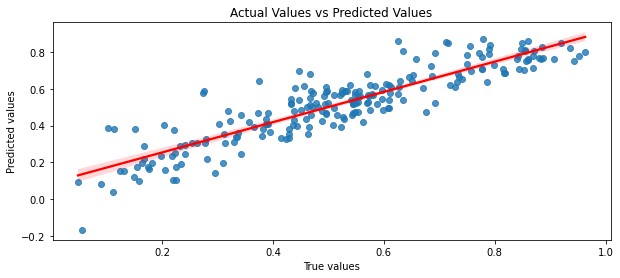

In [117]:
sns.regplot(x = y_test, y = y_pred_test, line_kws = {"color" : "red"})
plt.gcf().set_size_inches(10,4)
plt.title("Actual Values vs Predicted Values")
plt.xlabel("True values")
plt.ylabel('Predicted values')

## Observations:
- Our model was able to predict well, that means the model was able to generalise on the data with 80% accuracy
- Now we can use this model to conclude and achieve our buisness goals

In [118]:
lr_model.params

const        0.299477
yr           0.236298
temp         0.377143
windspeed   -0.154046
spring      -0.105047
winter       0.047588
December    -0.037435
January     -0.058615
September    0.062998
Tuesday     -0.047060
misty       -0.077965
snow_rain   -0.293356
dtype: float64

In [119]:
# The top three significant variables are: yr, temp and snow_rain


## Conclusion:
- BoomBikes already had a market for Bike rental which is explained by "const" which is 0.2999477 which is great for the company, so they can expect growth despite little investment, the reason for this trend could be that people are trying to reduce their carbon footprint and were encouraged to rather cycle; but there are sevral other factors as well like having fun, riding bikes to school, mountain biking wheere in most cases people tend to rent theri bikes because it porves to be cheapre to them cause they dont have to incur transport charges along with other miscellaneous charges with comes along you can refer the article below which goes along with our timeline: https://www.forbes.com/sites/timnewcomb/2020/07/13/amidst-cycling-surge-sport-of-mountain-biking-seeing-increased-sales-trail-usage/?sh=2c8fcbae3ddf

- Boom bikes should expand their business in the month of September as it shows the highest level of bikes rented

- Boom Bike should also see that they hand out lucrative offers when the weather conditions are Ideal and temperatures slightly on the higher end cause according to the data and model this will yield maximum rental bookings, the model also concludes that  BoomBikes should also focus more offers and equipments during winters as it may help drive the rental up in those months.

- From the EDA it was clear that the Fall, summer and winter had comparitively higher rental bookings, so Boom bikes must consider investing in its offers and promotion during these seasons and the months falling in these seasons.

- Last but not the least BoomBikes should increase their investments every year as we can saw that the company has the potential to grow maybe not in the pandemics as people were advised to  quarantine themselves but post covid where people are more likely and eager to enjoy the outdoors and rides, the company can see a tremendous growth coupled with the scenarios above they can successfully attract more customers.